In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
from numpy.typing import NDArray
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import imageio.v3 as iio
import matplotlib.pyplot as plt
from geovision.data.fmow import FMoW

def get_bbox_dims(bbox: list):
    return bbox[2], bbox[3]

def load_image(df: pd.DataFrame, idx: int):
    return iio.imread(FMoW.cold/df.iloc[idx]["image_path"])

def plot_original_image_with_bboxes(df: pd.DataFrame, idx: int):
    row = df.iloc[idx]
    _, ax = plt.subplots(1,1, figsize = (5,5))
    ax.imshow(load_image(df, idx))
    ax.add_patch(FMoW.get_rectangle_from_corners(
        (row["bbox_tl_0"], row["bbox_tl_1"]), (row["bbox_br_0"], row["bbox_br_1"]), fill = False, linewidth = 3, color = "red")
    )
    ax.add_patch(FMoW.get_rectangle_from_corners(
        (row["outer_bbox_tl_0"], row["outer_bbox_tl_1"]), (row["outer_bbox_br_0"], row["outer_bbox_br_1"]), fill = False, linewidth = 3, color = "blue")
    )
    
def crop_and_plot_image_with_bboxes(df: pd.DataFrame, idx: int):
    row = df.iloc[idx]
    image = load_image(df, idx) 
    image = crop_image_to_outer_bbox(image, row)

    _, ax = plt.subplots(1,1, figsize = (5,5))
    ax.imshow(image)
    ax.add_patch(FMoW.get_rectangle_from_corners(
        (row["inner_bbox_tl_0"], row["inner_bbox_tl_1"]), (row["inner_bbox_br_0"], row["inner_bbox_br_1"]), fill = False, linewidth = 3, color = "red")
    )
 
def update_bbox_to_superset_bbox(df: pd.DataFrame):
    pass

def calculate_outer_bbox(row: pd.Series) -> tuple[int, int, int, int]:
    # by row-major convention - dim_0: height, dim_1: width
    image_dims = row["height"], row["width"]
    bbox_tl, bbox_br = (row["super_bbox_tl_0"], row["super_bbox_tl_1"]), (row["super_bbox_br_0"], row["super_bbox_br_1"])
    bbox_dims = bbox_br[0] - bbox_tl[0], bbox_br[1] - bbox_tl[1]

    # bbox will be modified along the smaller dimension of the bbox, sdim
    sdim = np.argmin(bbox_dims)
    ldim = np.abs(sdim - 1)

    # skip over images smaller than 2000x2000
    if image_dims[ldim] < 2000:
        return 0, 0, *image_dims
    
    # calculate corrections along the smaller dimension 
    avail_before = bbox_tl[sdim] 
    avail_after = image_dims[ldim] - bbox_br[ldim]
    reqd = bbox_dims[ldim] - bbox_dims[sdim]
    if reqd % 2 == 0:
        reqd_before, reqd_after = reqd // 2, reqd // 2 
    else:
        reqd_before, reqd_after = (reqd // 2) + 1, reqd // 2

    # ajust corrections if bbox is not roughly in the center and there aren't enough pixels along
    # the smaller dimension; as much of the image as possible will be used
    if avail_before < reqd_before:
        reqd_after = min(avail_after, reqd_after + reqd_before - avail_before)
        reqd_before = avail_before
    elif avail_after < reqd_after:
        reqd_before = min(avail_before, reqd_before + reqd_after - avail_after)
        reqd_after = avail_after
    
    # apply the corrections
    new_bbox_tl = list(bbox_tl)
    new_bbox_tl[sdim] -= reqd_before
    new_bbox_br = list(bbox_br)
    new_bbox_br[sdim] += reqd_after

    return *new_bbox_tl, *new_bbox_br

def update_geometry_to_outer_bbox(row: pd.Series):
    pass

def calculate_inner_bbox(row: pd.Series) -> tuple[int, int, int, int]:
    return (
        row["bbox_tl_0"] - row["outer_bbox_tl_0"],
        row["bbox_tl_1"] - row["outer_bbox_tl_1"],
        row["bbox_br_0"] - row["outer_bbox_tl_0"],
        row["bbox_br_1"] - row["outer_bbox_tl_1"],
    )

def crop_image_to_outer_bbox(image: NDArray, row: pd.Series) -> NDArray:
    return image[row["outer_bbox_tl_0"]:row["outer_bbox_br_0"], row["outer_bbox_tl_1"]:row["outer_bbox_br_1"], :]

In [10]:
df = FMoW.get_multiclass_classification_df_from_metadata()
df

,image_path,label_str,img_height,img_width,bbox_tl_0,bbox_tl_1,bbox_br_0,bbox_br_1,mean_pixel_height,mean_pixel_width,...,super_bbox_br_0,super_bbox_br_1,outer_bbox_tl_0,outer_bbox_tl_1,outer_bbox_br_0,outer_bbox_br_1,inner_bbox_tl_0,inner_bbox_tl_1,inner_bbox_br_0,inner_bbox_br_1
0,seq/0009961/0009961_0_rgb.jpg,airport,8792,8792,3548,3702,4817,4829,0.000005,0.000005,...,4817,4829,3548,3631,4817,4900,0,71,1269,1198
1,seq/0009961/0009961_1_rgb.jpg,airport,8624,8624,3481,3631,4725,4737,0.000005,0.000005,...,4725,4737,3481,3562,4725,4806,0,69,1244,1175
2,seq/0004115/0004115_0_rgb.jpg,airport,7591,7793,2874,3021,4496,4924,0.000006,0.000006,...,4496,4924,2733,3021,4636,4924,141,0,1763,1903
3,seq/0004115/0004115_2_rgb.jpg,airport,8014,8226,3033,3188,4745,5198,0.000005,0.000005,...,4745,5198,2884,3188,4894,5198,149,0,1861,2010
4,seq/0004115/0004115_3_rgb.jpg,airport,9230,9474,3495,3673,5468,5987,0.000005,0.000005,...,5468,5987,3324,3673,5638,5987,171,0,2144,2314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545309,val/zoo/zoo_9/zoo_9_7_rgb.jpg,zoo,955,1105,332,246,586,785,0.000004,0.000004,...,586,785,0,0,955,1105,332,246,586,785
545310,val/zoo/zoo_9/zoo_9_8_rgb.jpg,zoo,816,944,284,210,501,672,0.000005,0.000005,...,501,672,0,0,816,944,284,210,501,672
545311,val/zoo/zoo_9/zoo_9_9_rgb.jpg,zoo,856,992,298,220,524,704,0.000005,0.000005,...,524,704,0,0,856,992,298,220,524,704
545312,val/zoo/zoo_9/zoo_9_5_rgb.jpg,zoo,753,871,262,194,462,620,0.000005,0.000005,...,462,620,0,0,753,871,262,194,462,620


In [46]:
with h5py.File("fmow.h5", "w") as h5file:
    row = df.iloc[0]
    images = h5file.create_dataset("images", 5, dtype = h5py.special_dtype(vlen = np.uint8))
    image = iio.imread(FMoW.local_staging/"rgb"/row["image_path"])
    image = image[row["outer_bbox_tl_0"]:row["outer_bbox_br_0"], row["outer_bbox_tl_1"]:row["outer_bbox_br_1"]]
    image = np.frombuffer(iio.imwrite('<bytes>', image, extension=".jpg"), dtype = np.uint8)
    images[0] = image

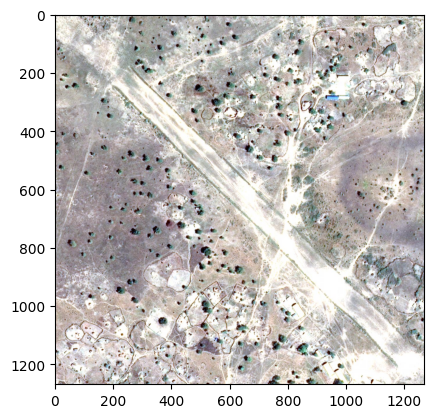

In [27]:
plt.imshow(image)

In [ ]:
df = FMoW.get_dataset_df_from_archive()
df["split"] = df["image_path"].apply(lambda x: str(x).split('/')[0])
#df = df[df["image_path"].apply(lambda x: str(x).startswith("train/"))]
df = df.drop(columns=["gsd", "utm", "loc", "timestamp"])
df = df[df["label_str"] != "false_detection"]
df[["bbox_tl_0", "bbox_tl_1", "bbox_br_0", "bbox_br_1"]] = df.apply(lambda x: FMoW.get_corners_from_bbox(x["bbox"]), axis = 1, result_type = "expand")
df = df.drop(columns = "bbox")
df = pd.merge(df, df.groupby("image_path").agg({"bbox_tl_0": "min", "bbox_tl_1": "min", "bbox_br_0": "max", "bbox_br_1": "max"}).add_prefix("super_").reset_index(drop = False), how = "left", on = "image_path")
# df[["outer_bbox_tl_0", "outer_bbox_tl_1", "outer_bbox_br_0", "outer_bbox_br_1"]] = df.apply(calculate_outer_bbox, axis = 1, result_type = "expand")
# df[["inner_bbox_tl_0", "inner_bbox_tl_1", "inner_bbox_br_0", "inner_bbox_br_1"]] = df.apply(calculate_inner_bbox, axis = 1, result_type = "expand")
df = df.reset_index(drop = True)

In [ ]:
df

,image_path,label_str,height,width,split,bbox_tl_0,bbox_tl_1,bbox_br_0,bbox_br_1,super_bbox_tl_0,super_bbox_tl_1,super_bbox_br_0,super_bbox_br_1
0,seq/airport/airport_0/airport_0_0_rgb.jpg,airport,8792,8792,seq,3548,3702,4817,4829,3548,3702,4817,4829
1,seq/airport/airport_0/airport_0_1_rgb.jpg,airport,8624,8624,seq,3481,3631,4725,4737,3481,3631,4725,4737
2,seq/airport/airport_1/airport_1_0_rgb.jpg,airport,7591,7793,seq,2874,3021,4496,4924,2874,3021,4496,4924
3,seq/airport/airport_1/airport_1_2_rgb.jpg,airport,8014,8226,seq,3033,3188,4745,5198,3033,3188,4745,5198
4,seq/airport/airport_1/airport_1_3_rgb.jpg,airport,9230,9474,seq,3495,3673,5468,5987,3495,3673,5468,5987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
545309,val/zoo/zoo_9/zoo_9_7_rgb.jpg,zoo,955,1105,val,332,246,586,785,332,246,586,785
545310,val/zoo/zoo_9/zoo_9_8_rgb.jpg,zoo,816,944,val,284,210,501,672,284,210,501,672
545311,val/zoo/zoo_9/zoo_9_9_rgb.jpg,zoo,856,992,val,298,220,524,704,298,220,524,704
545312,val/zoo/zoo_9/zoo_9_5_rgb.jpg,zoo,753,871,val,262,194,462,620,262,194,462,620


In [ ]:
superset_bbox_df = df.groupby("image_path").agg({"bbox_tl_0": "min", "bbox_tl_1": "min", "bbox_br_0": "max", "bbox_br_1": "max"})
superset_bbox_df = superset_bbox_df.reset_index(drop = False)
superset_bbox_df

,image_path,bbox_tl_0,bbox_tl_1,bbox_br_0,bbox_br_1
0,seq/airport/airport_0/airport_0_0_rgb.jpg,3548,3702,4817,4829
1,seq/airport/airport_0/airport_0_1_rgb.jpg,3481,3631,4725,4737
2,seq/airport/airport_1/airport_1_0_rgb.jpg,2874,3021,4496,4924
3,seq/airport/airport_1/airport_1_2_rgb.jpg,3033,3188,4745,5198
4,seq/airport/airport_1/airport_1_3_rgb.jpg,3495,3673,5468,5987
...,...,...,...,...,...
523841,val/zoo/zoo_9/zoo_9_5_rgb.jpg,262,194,462,620
523842,val/zoo/zoo_9/zoo_9_6_rgb.jpg,282,208,496,664
523843,val/zoo/zoo_9/zoo_9_7_rgb.jpg,332,246,586,785
523844,val/zoo/zoo_9/zoo_9_8_rgb.jpg,284,210,501,672


In [ ]:
no_bbox_df = df.drop(columns = ["bbox_tl_0", "bbox_tl_1", "bbox_br_0", "bbox_br_1"])
#display(no_bbox_df)
#display(superset_bbox_df)
pd.merge(no_bbox_df, superset_bbox_df, how = "left", on = "image_path")

,image_path,label_str,height,width,split,bbox_width,bbox_height,num_bbox_pixels,bbox_tl_0,bbox_tl_1,bbox_br_0,bbox_br_1
0,seq/airport/airport_0/airport_0_0_rgb.jpg,airport,8792,8792,seq,1127,1269,1430163,3548,3702,4817,4829
1,seq/airport/airport_0/airport_0_1_rgb.jpg,airport,8624,8624,seq,1106,1244,1375864,3481,3631,4725,4737
2,seq/airport/airport_1/airport_1_0_rgb.jpg,airport,7591,7793,seq,1903,1622,3086666,2874,3021,4496,4924
3,seq/airport/airport_1/airport_1_2_rgb.jpg,airport,8014,8226,seq,2010,1712,3441120,3033,3188,4745,5198
4,seq/airport/airport_1/airport_1_3_rgb.jpg,airport,9230,9474,seq,2314,1973,4565522,3495,3673,5468,5987
...,...,...,...,...,...,...,...,...,...,...,...,...
545309,val/zoo/zoo_9/zoo_9_7_rgb.jpg,zoo,955,1105,val,539,254,136906,332,246,586,785
545310,val/zoo/zoo_9/zoo_9_8_rgb.jpg,zoo,816,944,val,462,217,100254,284,210,501,672
545311,val/zoo/zoo_9/zoo_9_9_rgb.jpg,zoo,856,992,val,484,226,109384,298,220,524,704
545312,val/zoo/zoo_9/zoo_9_5_rgb.jpg,zoo,753,871,val,426,200,85200,262,194,462,620


In [ ]:
gr = pd.DataFrame(df.groupby("image_path").count()["label_str"])
gr.columns = ["count"]
gr = gr[gr["count"] > 1]
gr

,count
image_path,
seq/airport/airport_10/airport_10_0_rgb.jpg,3
seq/airport/airport_10/airport_10_1_rgb.jpg,3
seq/airport/airport_10/airport_10_4_rgb.jpg,3
seq/airport/airport_10/airport_10_5_rgb.jpg,3
seq/airport/airport_10/airport_10_6_rgb.jpg,3
...,...
test/zoo/zoo_44/zoo_44_0_rgb.jpg,3
test/zoo/zoo_8/zoo_8_0_rgb.jpg,2
test/zoo/zoo_8/zoo_8_1_rgb.jpg,2


In [ ]:
gr.value_counts()

count
2        5153
3        2387
4        1259
5         664
6         339
7         190
8         116
9          61
10         39
12         36
11         17
15          4
Name: count, dtype: int64

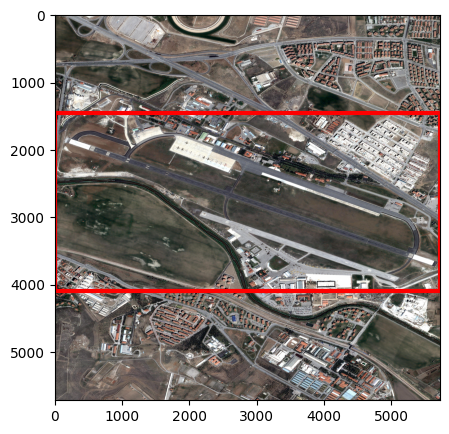

In [ ]:
crop_and_plot_image_with_bboxes(df, 1)

In [ ]:
# Image Height vs Width
# Insight: very few images are larger than 2000x2000px 
sns.jointplot(df, x = "width", y = "height")
print(df.apply(lambda x: True if x["width"] > 2000 or x["height"] > 2000 else False, axis = 1).sum(), "images have a dimention larger than 2000x2000px")

In [ ]:
# Classwise Distribution of Heights and Widths
# Insight: airport, amusement_park, impoverished_settlement, nuclear_powerplant, port, runway, shipyard and space facility are
# the ones with images > 2000px mostly, with a few outliers from each class
fig, axes = plt.subplots(1, 2, figsize = (20, 15))
sns.boxplot(df, y = "label_str", x = "height", ax = axes[0])
sns.boxplot(df, y = "label_str", x = "width", ax = axes[1])

In [ ]:
sns.jointplot(df, x = "bbox_width", y = "bbox_height")
print(df.apply(lambda x: True if x["width"] > 2000 or x["height"] > 2000 else False, axis = 1).sum(), "bboxes > 2000x2000px")

In [ ]:
df["bbox_height"] = df.apply(lambda x: x["bbox_br_0"] - x["bbox_tl_0"], axis = 1) 
df["bbox_width"] = df.apply(lambda x: x["bbox_br_1"] - x["bbox_tl_1"], axis = 1) 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 15))
sns.boxplot(df, y = "label_str", x = "bbox_height", ax = axes[0])
sns.boxplot(df, y = "label_str", x = "bbox_width", ax = axes[1])

In [ ]:
# Classwise distribution of images and pixels enclosed by bboxes
fig, axes = plt.subplots(1,2, figsize = (20, 15))
df["num_bbox_pixels"] = df.apply(lambda x: x["bbox_height"]*x["bbox_width"], axis = 1)
sns.barplot(df.groupby("label_str").count().reset_index(drop = False), y = "label_str", x = "image_path", ax = axes[0])
sns.barplot(df[["label_str", "num_bbox_pixels"]].groupby("label_str").sum().reset_index(drop = False), y = "label_str", x = "num_bbox_pixels", ax = axes[1])